# 1. 패키지 로딩 + 데이터 가져오기

In [28]:
# Data Manipulation Libraries
import numpy as np
import pandas as pd
from scipy import stats
import pyreadstat

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

# Machine Learning Libraries
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# Econometrics Libraries
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
import statsmodels.api as sm
from scipy.stats import norm

# Explainability Libraries
import shap

# Model Storage Libraries
import joblib

In [29]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)

In [30]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 2. 최장기 일자리 일을 그만둔 이유

E2_3 최장기 일자리_일을 그만둔 이유	
- 1	정년퇴직
- 2	건강이 좋지 않아서
- 3	정리해고, 명예퇴직, 폐업, 휴업
- 4	가사 문제(육아, 가사, 간병 등)
- 5	근로 조건 및 환경이 나빠서
- 6	이직, 창업
- 7	일할 필요가 없어서
- 8	기타
- 9	비해당

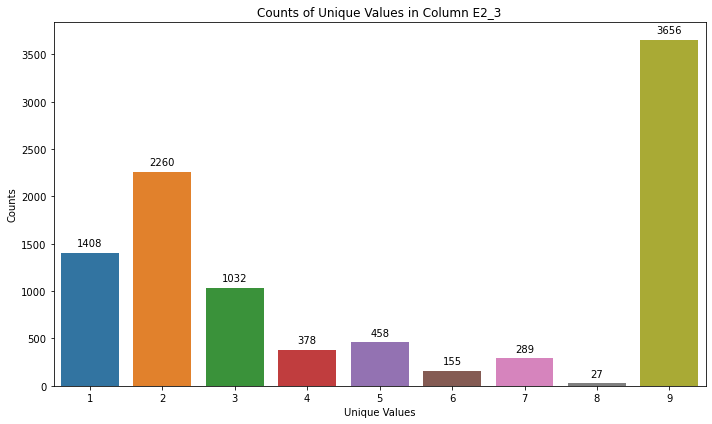

In [31]:
value_counts = df['E2_3'].value_counts()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=value_counts.index, y=value_counts.values)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100,
            '{:d}'.format(int(height)), ha='center', va='center')

plt.title('Counts of Unique Values in Column E2_3')
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

정리해고, 명예퇴직, 폐업, 휴업자는 1032명으로 나타났다. 

In [32]:
df = df[df['E2_3']==3]
conditions = [
    (df['RES_AGE'] >= 63) & (df['RES_AGE'] <= 72),
    (df['RES_AGE'] >= 73) & (df['RES_AGE'] <= 82),
    (df['RES_AGE'] >= 83) & (df['RES_AGE'] <= 92)
]
values = ["forty", "fifty", "sixty"]
df['treatment'] = np.select(conditions, values, default="rest")
df = df[df['treatment'] != "rest"]

# 4. Linear regressions

X:
- 건강: B1 (1->5 안 좋아짐)*(비해당:9)*
- 성별: RES_SEX <남자: 1, 여자: 2> -> categorical
- 교육수준: RES_EDU1 <1->7 높아짐>
-  지역 (광역시/도): AREA -> categortical
    - <11:서울 21:부산 22:대구 23:인천 24:광주 25:대전 26:울산 29:세종 31:경기 32:강원 33:충북 34:충남 35:전북 36:전남 37:경북 38:경남 39:제주>
- 지역: EDM 동부/읍면부 (1:동부 0:읍면부)
- 본인 총수입액 금액: J3b_1_13 
- 나이: RES_AGE
- 인지기능: I1x1 *(결측치:99)*

Y:
- 부동산자산비중: property_equity_ratio
- 금융자산비중: financial_equity_ratio
- 문화여가비비중: leisure_expense_ratio (월평균 여가비 소비/월평균 소비지출액)
- 우울증척도총점: B6_SUM
- 만족도_경제상태: H16_2 (1:매우 만족함 2:만족함 3:그저 그렇다 4:만족하지 않음 5:전혀 만족하지 않음)
- 만족도_삶 전반: H16_7  (1:매우 만족함 2:만족함 3:그저 그렇다 4:만족하지 않음 5:전혀 만족하지 않음)

In [33]:
AREAs = [11,21,22,23,24,25,26,29,31,32,33,34,35,36,37,38,39]
# 지역 값 바꿔주기
df['AREA'] = df['AREA'].replace({11:"Seoul", 21:"Busan", 22:"Daegu", 23:"Incheon", 24:"Gwangju", 25:"Daejeon", 
         26:"Ulsan", 29:"Sejong", 31:"Gyeonggi", 32:"Gangwon",
        33:"Chungbuk", 34:"Chungnam",35:"Jeonbuk",36:"Jeonnam",
        37:"Gyeongbuk",38:"Gyeongnam", 39:"Jeju"})

# Treatment 에 대한 one-hot encoding
treatment_dummies = pd.get_dummies(df['treatment'], prefix='treatment')
treatment_dummies = treatment_dummies.drop(columns=['treatment_sixty'])

# AREA에 대한 one-hot encoding
AREA_dummies = pd.get_dummies(df['AREA'], prefix='AREA')
AREA_dummies = AREA_dummies.drop(columns=['AREA_Seoul']) 

# Concatenate
treatment_columns = treatment_dummies.columns.tolist()
area_columns = AREA_dummies.columns.tolist()
df = pd.concat([df, treatment_dummies, AREA_dummies], axis=1)


X_columns = ['B1','RES_SEX','RES_EDU1','EDM','J3b_1_13','RES_AGE','I1x1'] + treatment_columns + area_columns
Y_options = ['property_equity_ratio','leisure_expense_ratio','B6_SUM','H16_2','H16_7']

X = df[X_columns]
X = sm.add_constant(X)

## 4.1 부동산자산 비중

property_equity_ratio
                              OLS Regression Results                             
Dep. Variable:     property_equity_ratio   R-squared:                       0.114
Model:                               OLS   Adj. R-squared:                  0.092
Method:                    Least Squares   F-statistic:                     5.189
Date:                   Fri, 18 Aug 2023   Prob (F-statistic):           5.59e-15
Time:                           01:07:07   Log-Likelihood:                 86.312
No. Observations:                   1031   AIC:                            -120.6
Df Residuals:                       1005   BIC:                             7.771
Df Model:                             25                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

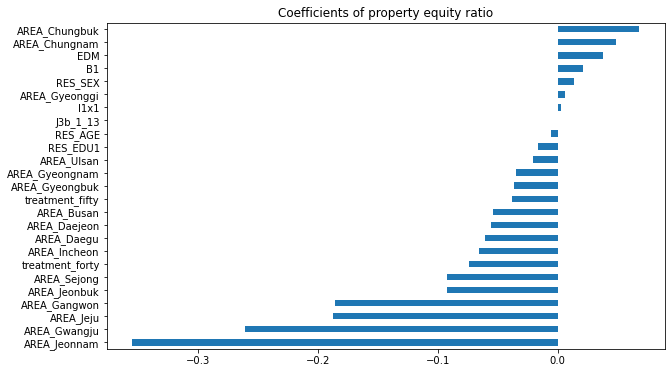

In [34]:
model = sm.OLS(df['property_equity_ratio'], X).fit()
               
print("property_equity_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of property equity ratio")
plt.show()

## 4.2 금융자산 비중

financial_equity_ratio
                              OLS Regression Results                              
Dep. Variable:     financial_equity_ratio   R-squared:                       0.104
Model:                                OLS   Adj. R-squared:                  0.082
Method:                     Least Squares   F-statistic:                     4.688
Date:                    Fri, 18 Aug 2023   Prob (F-statistic):           5.34e-13
Time:                            01:08:19   Log-Likelihood:                 203.99
No. Observations:                    1031   AIC:                            -356.0
Df Residuals:                        1005   BIC:                            -227.6
Df Model:                              25                                         
Covariance Type:                nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

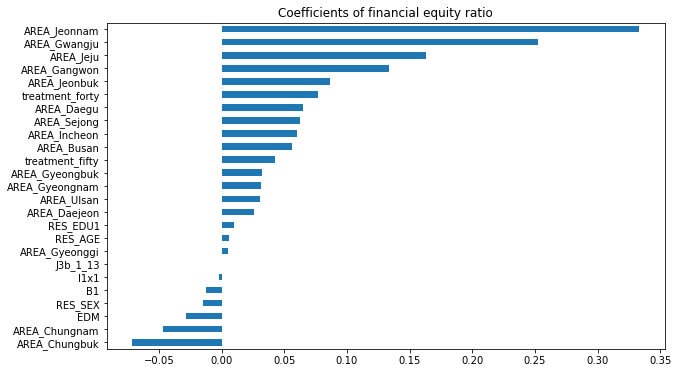

In [35]:
model = sm.OLS(df['financial_equity_ratio'], X).fit()
               
print("financial_equity_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of financial equity ratio")
plt.show()

## 3.3 문화여가비 비중

leisure_expense_ratio
                              OLS Regression Results                             
Dep. Variable:     leisure_expense_ratio   R-squared:                       0.184
Model:                               OLS   Adj. R-squared:                  0.164
Method:                    Least Squares   F-statistic:                     9.057
Date:                   Fri, 18 Aug 2023   Prob (F-statistic):           1.71e-30
Time:                           01:09:20   Log-Likelihood:                 1356.9
No. Observations:                   1031   AIC:                            -2662.
Df Residuals:                       1005   BIC:                            -2533.
Df Model:                             25                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

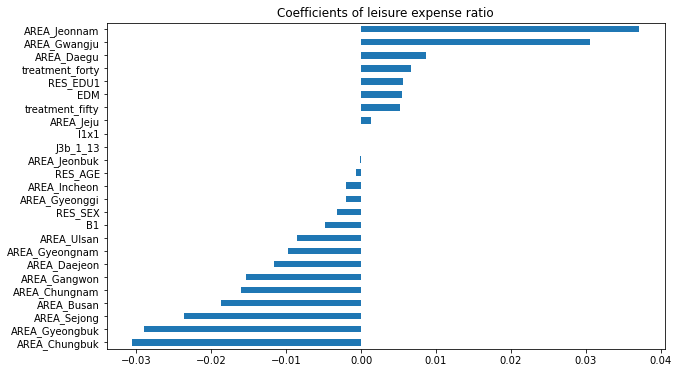

In [37]:
df['leisure_expense_ratio'] = df['J1b_3']/ df['J4']
model = sm.OLS(df['leisure_expense_ratio'], X).fit()
               
print("leisure_expense_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of leisure expense ratio")
plt.show()

## 3.4 우울증 척도 총점

Depression Score
                            OLS Regression Results                            
Dep. Variable:                 B6_SUM   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     11.34
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           1.75e-39
Time:                        01:09:48   Log-Likelihood:                -2371.8
No. Observations:                1031   AIC:                             4796.
Df Residuals:                    1005   BIC:                             4924.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.859

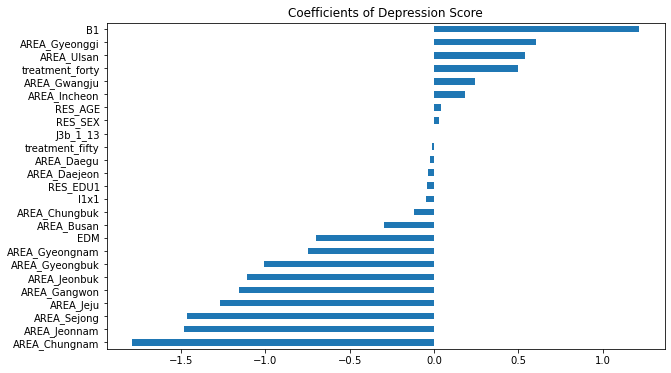

In [38]:
model = sm.OLS(df['B6_SUM'], X).fit()
               
print("Depression Score")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of Depression Score")
plt.show()

## 3.5 경제 상태 불만족도

Financial Discontent
                            OLS Regression Results                            
Dep. Variable:                  H16_2   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     11.95
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           7.38e-42
Time:                        01:10:14   Log-Likelihood:                -1232.9
No. Observations:                1031   AIC:                             2518.
Df Residuals:                    1005   BIC:                             2646.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0

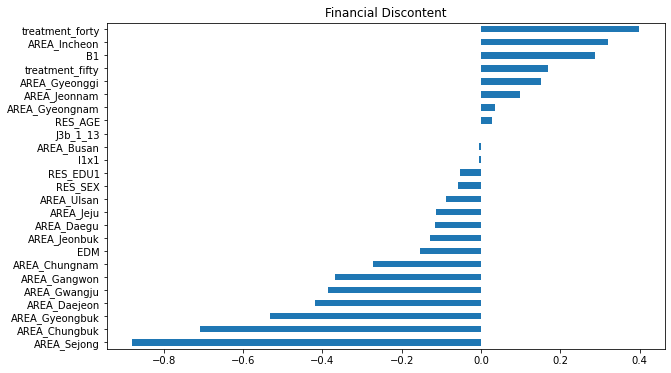

In [39]:
model = sm.OLS(df['H16_2'], X).fit()
               
print("Financial Discontent")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Financial Discontent")
plt.show()

## 3.6 삶 전반 불만족도

Life Discontent
                            OLS Regression Results                            
Dep. Variable:                  H16_7   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     13.42
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           1.68e-47
Time:                        01:11:22   Log-Likelihood:                -921.12
No. Observations:                1031   AIC:                             1894.
Df Residuals:                    1005   BIC:                             2023.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0186

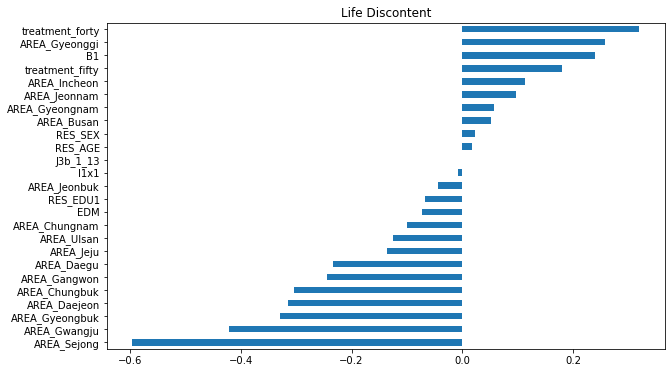

In [40]:
model = sm.OLS(df['H16_7'], X).fit()
               
print("Life Discontent")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Life Discontent")
plt.show()